In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [189]:
#getting a list of files to be read
ex_table_files = glob.glob('*_extracted_table.txt')
# Sort the list of files based on the numeric part in the filenames
ex_table_files = sorted(ex_table_files, key=lambda x: int(x.split('_')[0]), reverse=True)

In [190]:

df_list = []

#read in files to dataframes, selecting relevant columns
for file in ex_table_files:
    df = pd.read_csv(file, delim_whitespace=True
                     , skiprows=1) 
    df = df[['p1','p2','rg','se','z','p']]
    df = df.iloc[:-2]
    df_list.append(df)

In [191]:
df_list[0]

,p1,p2,rg,se,z,p
0,munged/ADHD.sumstats.gz,munged/ANOREXIA.sumstats.gz,-0.0931,0.0370,-2.5141,1.193500e-02
1,munged/ADHD.sumstats.gz,munged/ANXIETY.sumstats.gz,0.3234,0.1350,2.3950,1.661900e-02
2,munged/ADHD.sumstats.gz,munged/ASD.sumstats.gz,0.4326,0.0513,8.4319,3.402200e-17
3,munged/ADHD.sumstats.gz,munged/AUD.sumstats.gz,-0.0135,0.0261,-0.5154,6.062400e-01
4,munged/ADHD.sumstats.gz,munged/BIL_CHIR.sumstats.gz,0.0809,0.0416,1.9447,5.181000e-02
5,munged/ADHD.sumstats.gz,munged/BIP.sumstats.gz,0.2366,0.0331,7.1576,8.210900e-13
6,munged/ADHD.sumstats.gz,munged/CUD.sumstats.gz,0.6633,0.0428,15.4853,4.359100e-54
7,munged/ADHD.sumstats.gz,munged/EPILEPSY.sumstats.gz,0.1418,0.0539,2.6332,8.458800e-03
8,munged/ADHD.sumstats.gz,munged/FATIGUE.sumstats.gz,0.0760,0.0718,1.0575,2.902800e-01
9,munged/ADHD.sumstats.gz,munged/GOUT.sumstats.gz,0.0647,0.0371,1.7435,8.125000e-02


In [192]:
disorders = ['ADHD','ANOREXIA', 'ANXIETY','ASD','AUD','BIL. CHIR','BIP','CUD','EPILEPSY','FATIGUE','GOUT','HOARDING','IBS','LUPUS','MDD','MIGRAINE','MS','MYASTHENIA','OCD','OD','PANIC','PARKINSONS','PTSD','RH. ARTHRITIS','SJOGRENS','SZC','THYROID DIS.','TOURETTES']



In [193]:
def make_correlation_matrix(column, df_list):
    array = np.zeros((len(disorders), len(disorders)))

    # Assuming df_list is your list of dataframes
    for i, df in enumerate(df_list):
        val = df[column].values

        if len(val) > 0:  # Check if 'rg' column is not empty
            for j in range(i + 1, len(val) + 1 + i):  # Start from i + 1 to exclude the diagonal
                array[j, i] = val[j - i - 1]
                

    # Fill the diagonal with 1s
    if column == 'rg':            
        np.fill_diagonal(array, 1)
    else: np.fill_diagonal(array,0.000005)

    # Convert the filled cells to numeric (if the original values are not numeric)
    array = array.astype(float)

    # Create a DataFrame with disorders as column and index names
    return pd.DataFrame(array, index=disorders, columns=disorders)

In [196]:
corr_pval_df = make_correlation_matrix('p', df_list)
gen_corr_df = make_correlation_matrix('rg', df_list)

In [198]:
gen_corr_df

,ADHD,ANOREXIA,ANXIETY,ASD,AUD,BIL. CHIR,BIP,CUD,EPILEPSY,FATIGUE,...,OCD,OD,PANIC,PARKINSONS,PTSD,RH. ARTHRITIS,SJOGRENS,SZC,THYROID DIS.,TOURETTES
ADHD,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
ANOREXIA,-0.0931,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
ANXIETY,0.3234,-0.2092,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
ASD,0.4326,-0.1322,0.2647,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
AUD,-0.0135,-0.0607,0.1155,0.0661,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
BIL. CHIR,0.0809,0.0055,0.1038,0.0180,0.1217,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
BIP,0.2366,-0.2430,0.2686,0.2183,0.0607,0.0110,1.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
CUD,0.6633,-0.0398,0.3813,0.1174,0.0542,0.0628,0.2726,1.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
EPILEPSY,0.1418,-0.0050,0.2590,-0.1553,-0.1035,0.1138,-0.1440,-0.0042,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
FATIGUE,0.0760,-0.0890,0.4166,0.2495,0.0117,0.0170,0.2113,-0.0690,0.1297,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0


In [197]:
corr_pval_df

,ADHD,ANOREXIA,ANXIETY,ASD,AUD,BIL. CHIR,BIP,CUD,EPILEPSY,FATIGUE,...,OCD,OD,PANIC,PARKINSONS,PTSD,RH. ARTHRITIS,SJOGRENS,SZC,THYROID DIS.,TOURETTES
ADHD,5.000000e-06,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
ANOREXIA,1.193500e-02,5.000000e-06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
ANXIETY,1.661900e-02,1.443100e-01,0.000005,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
ASD,3.402200e-17,2.723300e-02,0.056900,5.000000e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
AUD,6.062400e-01,4.633800e-02,0.249300,8.473200e-02,5.000000e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
BIL. CHIR,5.181000e-02,9.173700e-01,0.520700,7.599300e-01,1.175000e-02,5.000000e-06,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
BIP,8.210900e-13,4.783400e-13,0.025100,2.242500e-06,1.834600e-02,8.172400e-01,5.000000e-06,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
CUD,4.359100e-54,4.119300e-01,0.021200,8.552200e-02,1.521600e-01,3.024600e-01,3.379300e-09,5.000000e-06,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
EPILEPSY,8.458800e-03,9.292300e-01,0.087200,2.177800e-02,1.256000e-02,8.814000e-02,1.936400e-03,9.562900e-01,0.000005,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
FATIGUE,2.902800e-01,3.362500e-01,0.190700,2.674800e-02,8.642100e-01,8.582700e-01,1.051300e-02,5.891200e-01,0.333900,0.000005,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Create a mask for the upper triangular part over the diagonal
mask = np.triu(np.ones_like(gen_corr_df), k=1)

# Plot the heatmap
plt.figure(figsize=(15,12))
sns.heatmap(gen_corr_df, cmap='coolwarm', mask=mask, square=True, cbar_kws={"shrink": 0.8})
plt.title('Genetic Correlation Heatmap')
plt.show()

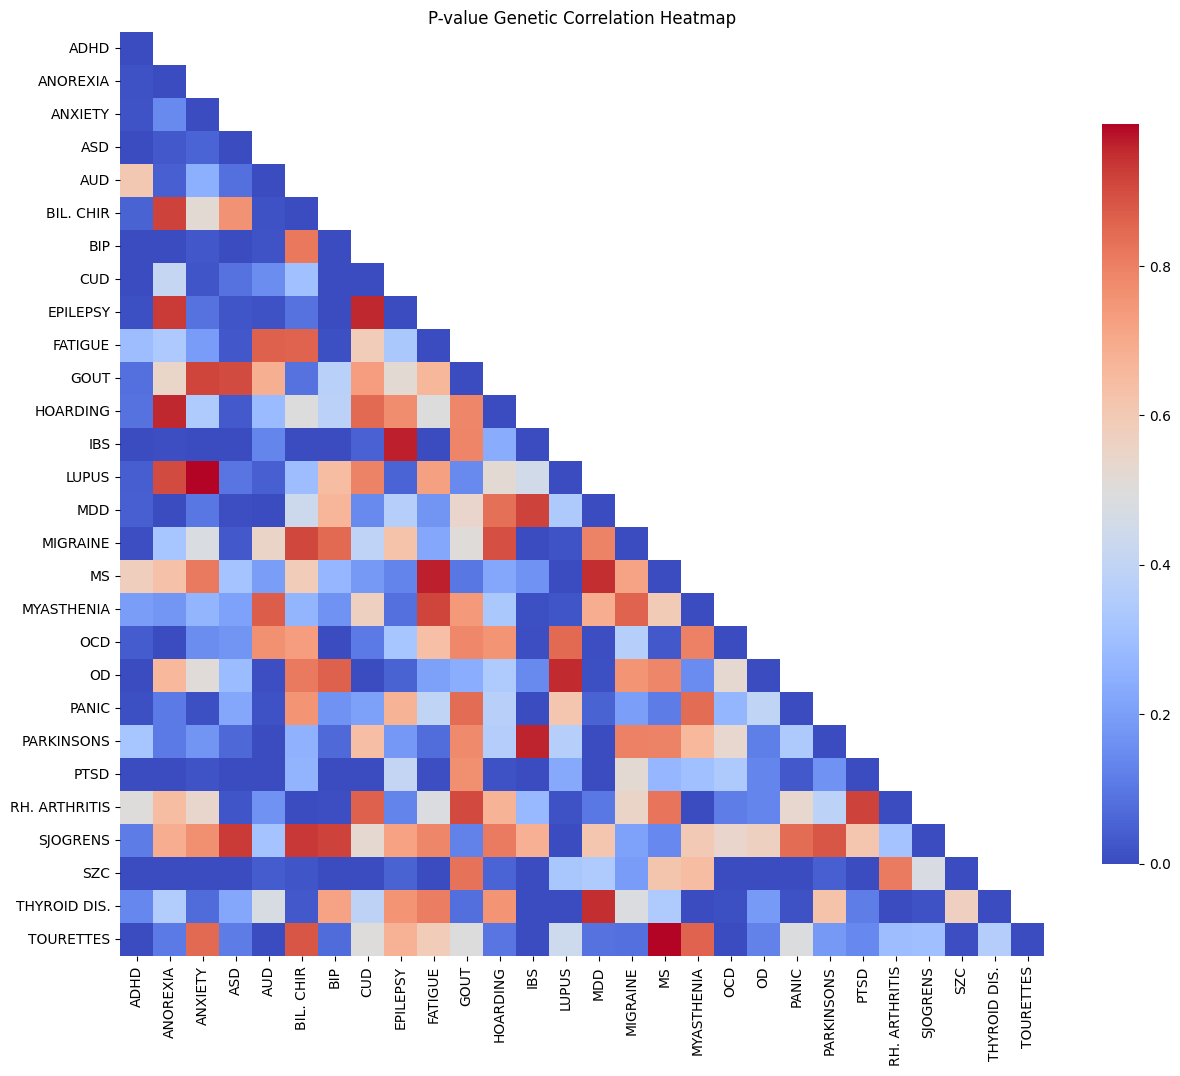

In [199]:
# Create a mask for the upper triangular part over the diagonal
mask = np.triu(np.ones_like(corr_pval_df), k=1)

# Plot the heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr_pval_df, cmap='coolwarm', mask=mask, square=True, cbar_kws={"shrink": 0.8})
plt.title('P-value Genetic Correlation Heatmap')
plt.show()